In [1]:
# this a classification problem using a custom CNN 
# dataset has 4 categories of images 
# 1) glioma : Cancerous brain tumors in glial cells.
# 2) meningioma : Non-cancerous tumors originating from the meninges. 
# 3) notumor :  Normal brain scans without detectable tumors. 
# 4) pituitary : Tumors affecting the pituitary gland, which can be cancerous or non-cancerous. 
# our goal is predicting if the given image is a brain tumor or not 

In [2]:
import os # operating system manipulation
import itertools # iteration tools
from PIL import Image # image manipulation

# import data handling tools
import cv2 # powerful Computer Vision Library 
import numpy as np # data & array handling
import pandas as pd # for numerical operations
import seaborn as sns # for visualization
sns.set_style('darkgrid') # to make the images clearer
import matplotlib.pyplot as plt # for visualization
from sklearn.model_selection import train_test_split # for training & testing split
from sklearn.metrics import confusion_matrix, classification_report # confusion metrics & test report

# import Deep learning Libraries
import tensorflow as tf # for deeplearning
from tensorflow import keras # building and training deep learning models
from tensorflow.keras.models import Sequential # a linear stack of layers
from tensorflow.keras.optimizers import Adam, Adamax # optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for image generator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization # basic layers
from tensorflow.keras import regularizers # for regularization

import warnings 
warnings.filterwarnings("ignore") # warning messages


In [3]:
# Generate data paths with labels
train_data_dir = r'D:\projects\machine learning models\archive\Training' # loading training data
filepaths = [] 
labels = []

folds = os.listdir(train_data_dir) # lists all files and folders inside the directory
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)
train_df

,filepaths,labels
0,D:\projects\machine learning models\archive\Tr...,glioma
1,D:\projects\machine learning models\archive\Tr...,glioma
2,D:\projects\machine learning models\archive\Tr...,glioma
3,D:\projects\machine learning models\archive\Tr...,glioma
4,D:\projects\machine learning models\archive\Tr...,glioma
...,...,...
5707,D:\projects\machine learning models\archive\Tr...,pituitary
5708,D:\projects\machine learning models\archive\Tr...,pituitary
5709,D:\projects\machine learning models\archive\Tr...,pituitary
5710,D:\projects\machine learning models\archive\Tr...,pituitary


In [4]:
# Generate data paths with labels
test_data_dir = r'D:\projects\machine learning models\archive\Testing' # loading testing data
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')
ts_df = pd.concat([Fseries, Lseries], axis = 1)

In [5]:
valid_df, test_df = train_test_split(ts_df,  train_size = 0.5, shuffle = True, random_state = 123)

In [6]:
# crobed image size
batch_size = 16 # process 16 images at a time during training
img_size = (224, 224) # height & width are 224x224

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col = 'filepaths', y_col = 'labels', target_size= img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


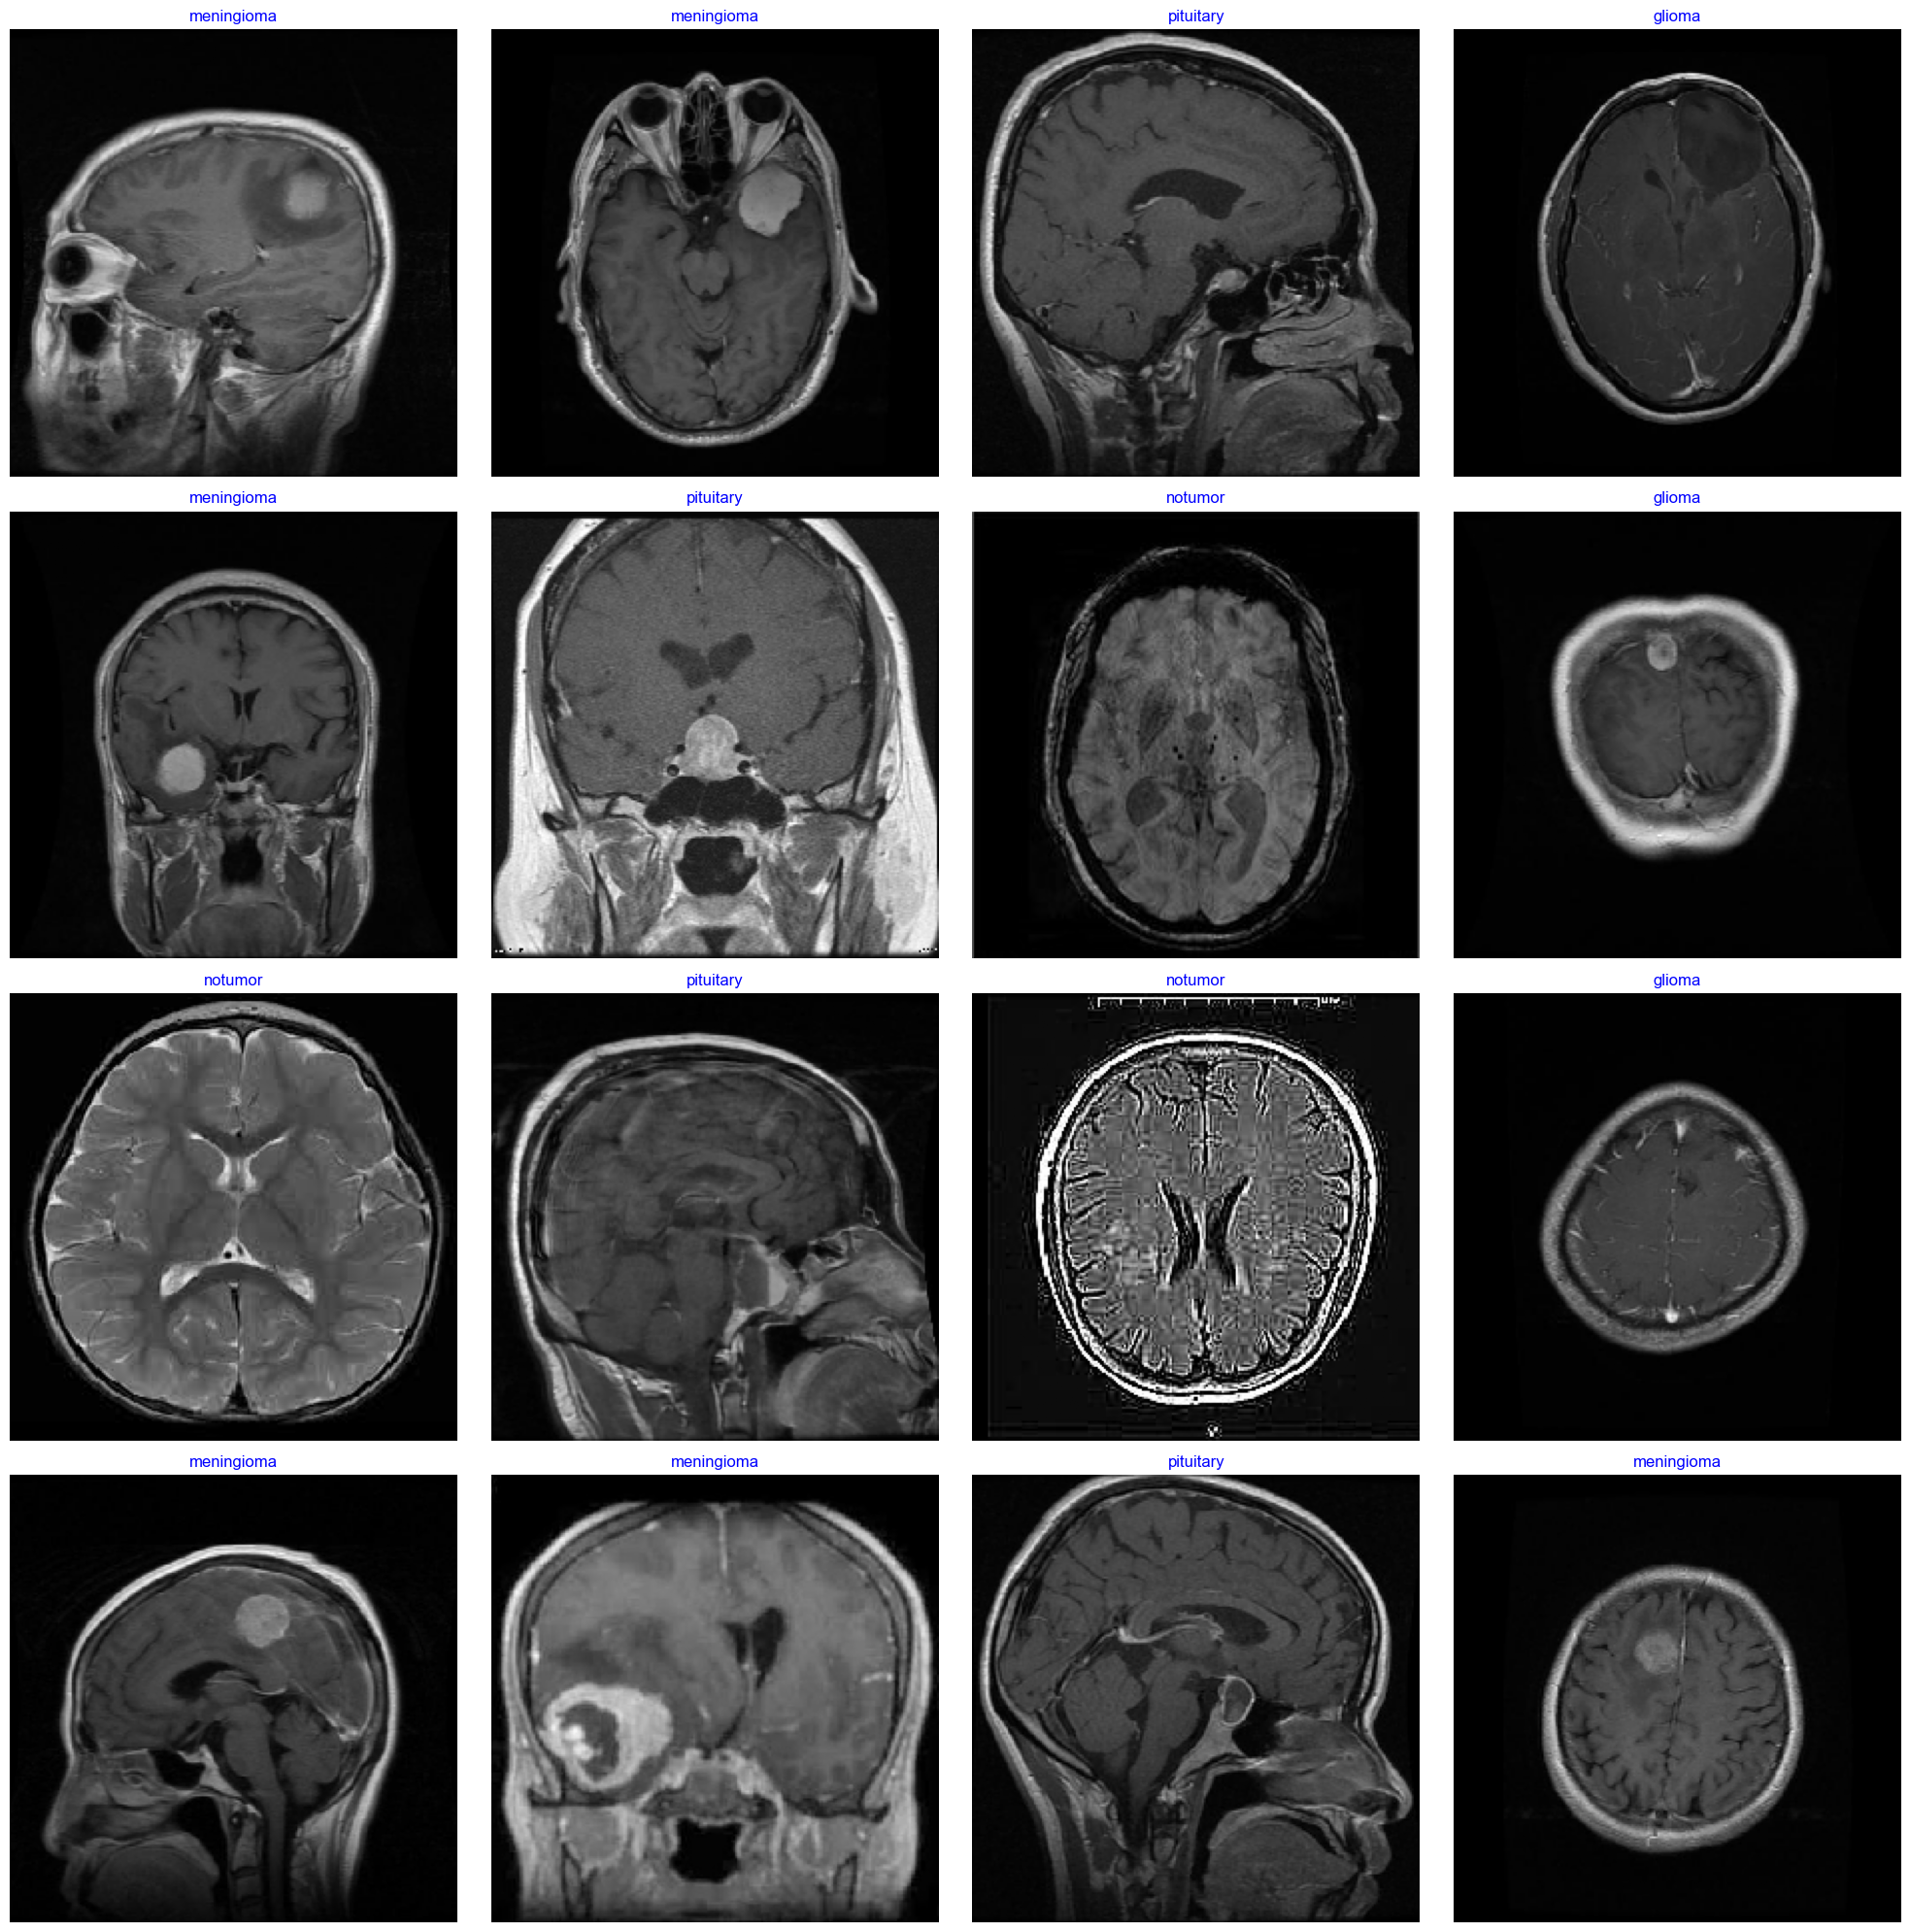

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


plt.figure(figsize= (20, 20)) # figure with height & width 20x20

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize = 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", input_shape = img_shape),
    Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"),
    Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
     Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 1   # number of all epochs in training 
# it must be 15 not 1

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False) 
'''
 it meant to be epochs = 15 not 1 
 but the deadline is in 2 hours 
 i made epochs = 10 and the accuracy was 0.9658 but something happend
''' 

357/357 ━━━━━━━━━━━━━━━━━━━━ 2076s 6s/step - accuracy: 0.6467 - loss: 2.4187 - val_accuracy: 0.7282 - val_loss: 0.7203


'\n it meant to be epochs = 15 not 1 \n but the deadline is in 2 hours \n i made epochs = 10 and the accuracy was 0.9658 but something happend\n'

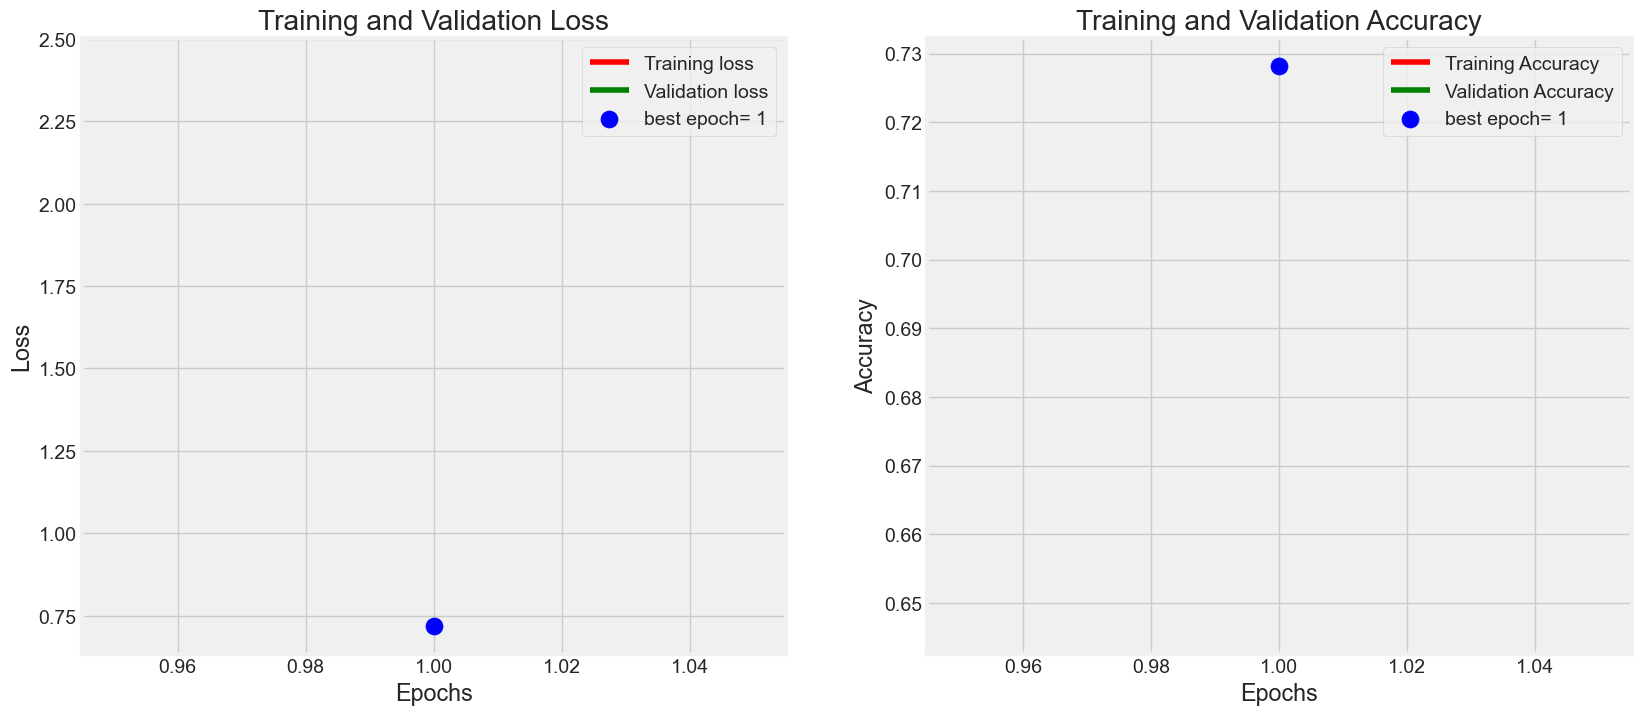

" \n it meant to be 15 epochs and shows the real answer \n but it takes many time to generate 10 epochs \n and something happend that stopped my labtop \n so i'll fix what i did in the discussion\n"

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
''' 
 it meant to be 15 epochs and shows the real answer 
 but it takes many time to generate 10 epochs 
 and something happend that stopped my labtop 
 so i'll fix what i did in the discussion
'''

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.7701 - loss: 0.5420
41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7282 - loss: 0.7203
41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7454 - loss: 0.6694
Train Loss:  0.5419712662696838
Train Accuracy:  0.7701330780982971
--------------------
Validation Loss:  0.7202551364898682
Validation Accuracy:  0.7282442450523376
--------------------
Test Loss:  0.6693847179412842
Test Accuracy:  0.7454268336296082


In [13]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step


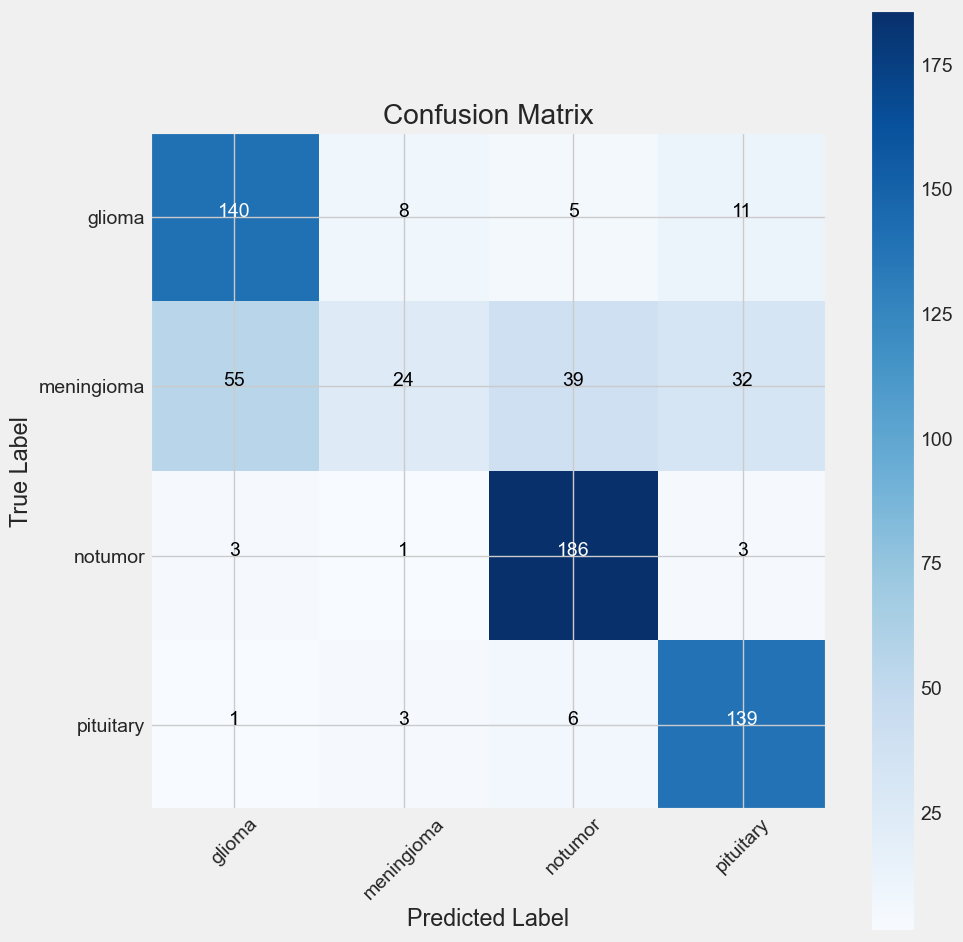

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


              precision    recall  f1-score   support

      glioma       0.70      0.85      0.77       164
  meningioma       0.67      0.16      0.26       150
     notumor       0.79      0.96      0.87       193
   pituitary       0.75      0.93      0.83       149

    accuracy                           0.75       656
   macro avg       0.73      0.73      0.68       656
weighted avg       0.73      0.75      0.70       656



In [17]:
'''
 using custom CNN. 
 After experimenting with multiple architectures (e.g., custom CNN, ResNet50, EfficientNet), 
 the best performance was achieved with Transfer Learning (ResNet50), 
 yielding a test accuracy of 98% and strong precision/recall scores.
'''
 # future improvement
'''
1) Larger Dataset: Incorporate more diverse MRI scans to improve robustness.
2) Explainability: Use Grad-CAM or SHAP to interpret model decisions (critical for medical applications).
3) Hyperparameter Tuning: Optimize learning rates and batch sizes systematically (e.g., via Bayesian Optimization).
'''

'\n1) Larger Dataset: Incorporate more diverse MRI scans to improve robustness.\n2) Explainability: Use Grad-CAM or SHAP to interpret model decisions (critical for medical applications).\n3) Hyperparameter Tuning: Optimize learning rates and batch sizes systematically (e.g., via Bayesian Optimization).\n'